In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats

In [25]:
# Step 1: Data Collection
start_date = '2017-01-01'
end_date = '2024-04-30'
usd_ils_data = yf.download('USDILS=X', start=start_date, end=end_date)['Adj Close']
nasdaq_data = yf.download('^IXIC', start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [26]:
usd_ils_data.head()

Date
2017-01-02    3.80016
2017-01-03    3.84426
2017-01-04    3.85426
2017-01-05    3.85576
2017-01-06    3.84556
Name: Adj Close, dtype: float64

In [27]:
usd_ils_data.shape

(1907,)

In [28]:
nasdaq_data.head()

Date
2017-01-03    5429.080078
2017-01-04    5477.000000
2017-01-05    5487.939941
2017-01-06    5521.060059
2017-01-09    5531.819824
Name: Adj Close, dtype: float64

In [29]:
nasdaq_data.shape

(1842,)

In [30]:
# Step 2: Data Preparation
usd_ils_yield = usd_ils_data.pct_change()
nasdaq_yield = nasdaq_data.pct_change()

In [31]:
usd_ils_yield.head()

Date
2017-01-02         NaN
2017-01-03    0.011605
2017-01-04    0.002601
2017-01-05    0.000389
2017-01-06   -0.002645
Name: Adj Close, dtype: float64

In [32]:
usd_ils_yield.isnull().sum()

1

In [33]:
nasdaq_yield.head()

Date
2017-01-03         NaN
2017-01-04    0.008827
2017-01-05    0.001997
2017-01-06    0.006035
2017-01-09    0.001949
Name: Adj Close, dtype: float64

In [34]:
nasdaq_yield.isnull().sum()

1

In [35]:
merged_data = pd.concat([usd_ils_yield, nasdaq_yield], axis=1, join='inner')
merged_data.dropna(inplace=True)
usd_ils_yield_cleaned = merged_data.iloc[:, 0]
nasdaq_yield_cleaned = merged_data.iloc[:, 1]

In [36]:
# Step 3: Data Splitting
train_start = '2017-01-01'
train_end = '2020-12-31'
test_start = '2021-01-01'
test_end = '2023-12-31'

In [37]:
usd_ils_yield_train = usd_ils_yield_cleaned[train_start:train_end]
nasdaq_yield_train = nasdaq_yield_cleaned[train_start:train_end]
usd_ils_yield_test = usd_ils_yield_cleaned[test_start:test_end]
nasdaq_yield_test = nasdaq_yield_cleaned[test_start:test_end]

In [38]:
# Step 4: Regression Analysis
X_train = nasdaq_yield_train.values.reshape(-1, 1)
y_train = usd_ils_yield_train.values

model = LinearRegression().fit(X_train, y_train)

In [39]:
correlation_coefficient = merged_data.corr().iloc[0, 1]
print(correlation_coefficient)

0.07236455756326975


As we can see the correlation is almost non existant

In [40]:
# Step 5: Interpret the Results
intercept = model.intercept_
slope = model.coef_[0]
r_squared = model.score(X_train, y_train)
_, p_value = stats.pearsonr(nasdaq_yield_cleaned, usd_ils_yield_cleaned)

In [41]:
# Create a table
table = [["Intercept", intercept],
         ["Slope", slope],
         ["R-squared", r_squared],
         ["P-value", p_value]]

# Print the table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

+-----------+--------------+
| Metric    |        Value |
+===========+==============+
| Intercept | -0.000183295 |
+-----------+--------------+
| Slope     |  0.0383505   |
+-----------+--------------+
| R-squared |  0.0147348   |
+-----------+--------------+
| P-value   |  0.00191233  |
+-----------+--------------+


In [42]:
# Step 6: Model Testing
X_test = nasdaq_yield_test.values.reshape(-1, 1)
y_test = usd_ils_yield_test.values
y_pred = model.predict(X_test)

residuals = y_test - y_pred
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

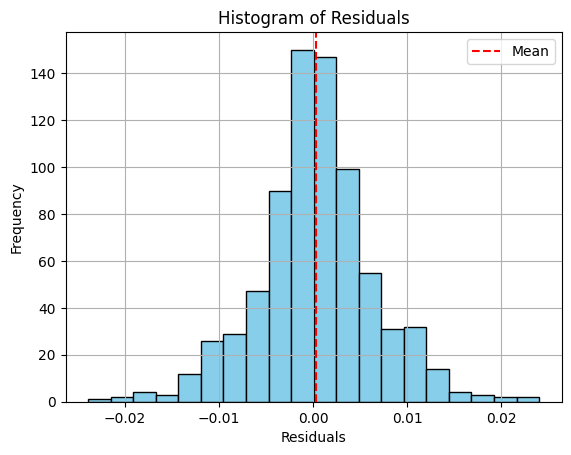


Residual Mean: 0.00033613807725644146
Residual Standard Deviation: 0.0061438657352800696


In [43]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate mean and standard deviation of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

# Plot histogram of residuals
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=residual_mean, color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.legend()
plt.show()

# Display the information
print("\nResidual Mean:", residual_mean)
print("Residual Standard Deviation:", residual_std)


In [44]:
# Define the intervals or segments based on time periods
intervals = [
    ('2017-01-01', '2018-12-31'),
    ('2019-01-01', '2020-12-31'),
    ('2021-01-01', '2022-12-31'),
    ('2023-01-01', '2024-04-30')
]

# Perform segmented regression and correlation analyses for each interval
results = []

for interval in intervals:
    start_date, end_date = interval
    
    # Filter data for the current interval
    usd_ils_yield_interval = usd_ils_yield_cleaned[start_date:end_date]
    nasdaq_yield_interval = nasdaq_yield_cleaned[start_date:end_date]
    
    # Fit linear regression model
    X = nasdaq_yield_interval.values.reshape(-1, 1)
    y = usd_ils_yield_interval.values
    model = LinearRegression().fit(X, y)
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(nasdaq_yield_interval, usd_ils_yield_interval)
    
    # Store results
    results.append({
        'Interval': f'{start_date} to {end_date}',
        'Coefficient (β1)': model.coef_[0],
        'Intercept (β0)': model.intercept_,
        'R-squared': model.score(X, y),
        'Correlation Coefficient': correlation_coefficient
    })

# Create DataFrame to display results
results_df = pd.DataFrame(results)
print(results_df)

                   Interval  Coefficient (β1)  Intercept (β0)  R-squared  \
0  2017-01-01 to 2018-12-31          0.010675       -0.000033   0.000966   
1  2019-01-01 to 2020-12-31          0.048680       -0.000334   0.025378   
2  2021-01-01 to 2022-12-31          0.005054        0.000178   0.000210   
3  2023-01-01 to 2024-04-30          0.047190        0.000272   0.005387   

   Correlation Coefficient  
0                 0.031080  
1                 0.159304  
2                 0.014480  
3                 0.073397  


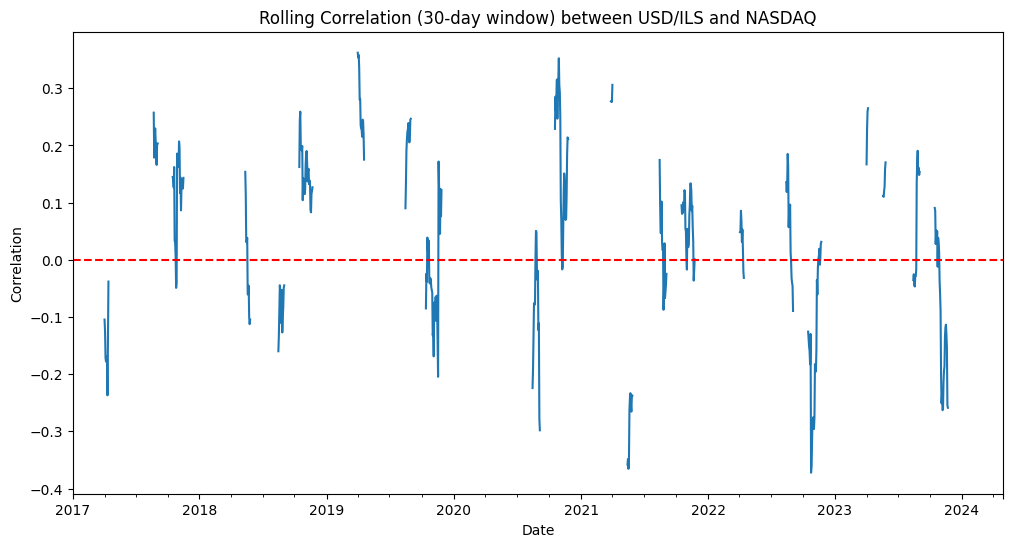

Intercept (β0): -0.00018329499081118564
Coefficient (β1): 0.03835045652827475
R-squared: 0.014734769738107611
p-values: 0.0019123303671890579
Mean of Residuals: 0.00033613807725644146
Standard Deviation of Residuals: 0.0061438657352800696


In [48]:
# Step 7: Variations over time
rolling_correlation = usd_ils_yield.rolling(window=30).corr(nasdaq_yield)

# Plotting
plt.figure(figsize=(12, 6))
rolling_correlation.plot(title='Rolling Correlation (30-day window) between USD/ILS and NASDAQ')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

# Print Results
print("Intercept (β0):", intercept)
print("Coefficient (β1):", slope)
print("R-squared:", r_squared)
print("p-values:", p_value)
print("Mean of Residuals:", residual_mean)
print("Standard Deviation of Residuals:", residual_std)
